# Classification decision tree model

First of all, we will import the necessary libraries for the assignment and implement the decision tree model for the classifier.

In [1]:
import numpy as np
import pandas as pd
# The tqdm module is used to display the progress bar and the time taken for the model to train.
from tqdm import tqdm
import matplotlib.pyplot as plt

# The following modules, BaseEstimator, ClassifierMixin, RegressorMixin are used to create custom models that can be used with the scikit-learn library for further analysis.
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin

# Decision Tree Classifier (with Gini impurity)
class DecisionTree(BaseEstimator, ClassifierMixin):
    # The __init__ function is a constructor that is used to initialize the class variables.
    # We set the default values for the minimum number of samples and the maximum depth of the tree by the hyperparameters tuning that we did post the implementation of the model.
    def __init__(self, min_samples_split=10, max_depth=7):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.tree = None


    # The fit function is used to train the model on the training data.
    def fit(self, X, y):
        # The classes variable is used to store the unique classes in the target variable.
        self.classes = np.unique(y)
        # The y variable is converted to an array of indices of the classes variable.
        y = np.array([np.where(self.classes == label)[0][0] for label in y])
        # The tree variable is used to store the decision tree that is trained on the training data with the help of the _grow_tree function.
        self.tree = self._grow_tree(X, y)
    
    # The predict function is used to predict the target variable for the test data.
    def predict(self, X):
        # The predictions variable is used to store the predictions made by the model on the test data after training.
        predictions = [self._predict(inputs, self.tree) for inputs in X]
        # The predictions variable is converted to the original target variable by using the classes variable and the indices of the predictions variable.
        return np.array([self.classes[pred] for pred in predictions])

    # The _gini function is used to calculate the Gini impurity of the target variable.
    def _gini(self, y):
        # The m variable is used to store the number of samples in the target variable.
        m = len(y)
        # We return the Gini impurity of the target variable by using the formula for Gini impurity.
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

    # The _split function is used to split the data into left and right nodes based on the threshold value.
    def _split(self, X, y, idx, thresh):
        left_mask = X[:, idx] <= thresh
        right_mask = X[:, idx] > thresh
        # We return the left and right nodes of the data based on the threshold value.
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

    # The _best_split function is used to find the best split for the data based on the Gini impurity.
    def _best_split(self, X, y):
        # The m and n variables are used to store the number of samples and features in the data.
        m, n = X.shape
        # if number of samples is less than or equal to min_samples_split, return None
        if m <= self.min_samples_split:
            return None, None

        # The best_gini variable is used to store the best Gini impurity value and keep track of the best split.
        best_gini = 1.0
        # The best_idx and best_thresh variables are used to store the best feature index and threshold value for the best split.
        best_idx, best_thresh = None, None
        # The unique_classes variable is used to store the unique classes in the target variable.
        unique_classes = np.unique(y)
        # The class_count variable is used to store the number of unique classes in the target variable.
        class_count = len(unique_classes)

        # We iterate over each feature in the data to find the best split based on the Gini impurity.
        for idx in range(n):
            # zip function is used to sort the data based on the feature values. once the data is sorted, we unzip the data to get the sorted feature values and target variable values.
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            # We convert the thresholds variable to an array of float64 type.
            thresholds = np.array(thresholds, dtype=np.float64)
            # The num_left and num_right variables are used to store the number of samples in the left and right nodes of the data.
            num_left = [0] * class_count
            num_right = [np.sum(classes == c) for c in unique_classes]


            # We iterate over each sample in the data to find the best split based on the Gini impurity.
            for i in range(1, m):
                # The class_idx variable is used to store the index of the class in the unique_classes variable.
                class_idx = np.where(unique_classes == classes[i - 1])[0][0]
                # We update the number of samples in the left and right nodes of the data.
                num_left[class_idx] += 1
                num_right[class_idx] -= 1

                # The gini_left and gini_right variables are used to store the Gini impurity of the left and right nodes of the data.
                gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in range(class_count))
                gini_right = 1.0 - sum((num_right[x] / (m - i)) ** 2 for x in range(class_count))
                # We calculate the Gini impurity of the split based on the left and right nodes of the data.
                gini = (i * gini_left + (m - i) * gini_right) / m

                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thresh = (thresholds[i] + thresholds[i - 1]) / 2
        
        return best_idx, best_thresh

    # The _grow_tree function is used to grow the decision tree based on the training data.
    def _grow_tree(self, X, y, depth=0):
        # The num_samples_per_class variable is used to store the number of samples in each class of the target variable.
        num_samples_per_class = [np.sum(y == i) for i in np.unique(y)]
        # The predicted_class variable is used to store the class with the maximum number of samples.
        predicted_class = np.argmax(num_samples_per_class)
        # The node variable is used to store the decision tree node.
        node = {'predicted_class': predicted_class}

        # We check if the depth of the tree is less than the maximum depth and find the best split for the data.
        if depth < self.max_depth:
            # The idx and thresh variables are used to store the best feature index and threshold value for the best split.
            idx, thresh = self._best_split(X, y)
            # We check if the best feature index and threshold value are not None and split the data into left and right nodes.
            if idx is not None:
                indices_left = X[:, idx] <= thresh
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                # We check if the number of samples in the left and right nodes is greater than the minimum number of samples to split.
                node['feature_index'] = idx
                node['threshold'] = thresh
                # We recursively grow the left and right nodes of the decision tree.
                node['left'] = self._grow_tree(X_left, y_left, depth + 1)
                node['right'] = self._grow_tree(X_right, y_right, depth + 1)
        return node

    # The _predict function is used to predict the target variable for the test data based on the decision tree.
    def _predict(self, inputs, tree):
        # We check if the tree node has the threshold value and split the data into left and right nodes based on the threshold value.
        if 'threshold' in tree:
            feature_index = tree['feature_index']
            if inputs[feature_index] <= tree['threshold']:
                # We recursively predict the target variable for the left node of the decision tree.
                return self._predict(inputs, tree['left'])
            else:
                # We recursively predict the target variable for the right node of the decision tree.
                return self._predict(inputs, tree['right'])
        else:
            # If the tree node does not have the threshold value, we return the predicted class of the tree node.
            return tree['predicted_class']




# Regressor decision tree model

In [2]:

# Decision Tree Regressor with BaseEstimator and RegressorMixin for custom model creation and comparison with scikit-learn models.
class DecisionTreeRegressor(BaseEstimator, RegressorMixin):
    # As we did for the DecisionTree Classifier, we set the default values for the minimum number of samples and the maximum depth of the tree by the hyperparameters tuning that we did post the implementation of the model.
    def __init__(self, min_samples_split=10, max_depth=7):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.tree = None

    # The fit function is used to train the model on the training data.
    def fit(self, X, y):
        # In difference to the DecisionTree Classifier, we do not need to convert the target variable to indices of the classes variable.
        self.tree = self._grow_tree(X, y)
    
    # The predict function is used to predict the target variable for the test data.
    def predict(self, X):
    
        return np.array([self._predict(inputs, self.tree) for inputs in X])

    # The _ssr function is used to calculate the sum of squared residuals of the target variable.
    def _ssr(self, y):
        # We calculate the mean value of the target variable.
        if len(y) == 0:
            return 0
        mean_y = np.mean(y)
        # We return the sum of squared residuals of the target variable.
        return np.sum((y - mean_y) ** 2)

    # The _split function is used to split the data into left and right nodes based on the threshold value.
    def _split(self, X, y, idx, thresh):
        left_mask = X[:, idx] <= thresh
        right_mask = X[:, idx] > thresh
        # We return the left and right nodes of the data based on the threshold value.
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

    # The _best_split function is used to find the best split for the data based on the sum of squared residuals.
    def _best_split(self, X, y):
        m, n = X.shape
        if m <= self.min_samples_split:
            return None, None

        # The best_ssr variable is used to store the best sum of squared residuals value and keep track of the best split.
        best_ssr = np.inf
        best_idx, best_thresh = None, None

        # We iterate over each feature in the data to find the best split based on the sum of squared residuals.
        for idx in range(n):
            thresholds, values = zip(*sorted(zip(X[:, idx], y)))
            # We iterate over each sample in the data to find the best split based on the sum of squared residuals.
            for i in range(1, m):
                y_left, y_right = values[:i], values[i:]
                # We calculate the sum of squared residuals of the left and right nodes of the data.
                ssr_left, ssr_right = self._ssr(y_left), self._ssr(y_right)
                ssr = ssr_left + ssr_right

                # We check if the sum of squared residuals is less than the best sum of squared residuals and update the best split.
                if thresholds[i] == thresholds[i - 1]:
                    continue
                # If the sum of squared residuals is less than the best sum of squared residuals, we update the best split.
                if ssr < best_ssr:
                    best_ssr = ssr
                    best_idx = idx
                    best_thresh = (thresholds[i] + thresholds[i - 1]) / 2

        # We return the best feature index and threshold value for the best split.
        return best_idx, best_thresh
    

    # Similar to the DecisionTree Classifier, the _grow_tree function is used to grow the decision tree based on the training data.
    def _grow_tree(self, X, y, depth=0):
        if len(y) == 0:
            return None
        predicted_value = np.mean(y)
        node = {'predicted_value': predicted_value}

        # We check if the depth of the tree is less than the maximum depth and find the best split for the data.
        if depth < self.max_depth:
            idx, thresh = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] <= thresh
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node['feature_index'] = idx
                node['threshold'] = thresh
                node['left'] = self._grow_tree(X_left, y_left, depth + 1)
                node['right'] = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _predict(self, inputs, tree):
        if 'threshold' in tree:
            feature_index = tree['feature_index']
            if inputs[feature_index] <= tree['threshold']:
                return self._predict(inputs, tree['left'])
            else:
                return self._predict(inputs, tree['right'])
        else:
            return tree['predicted_value']

# Random forest model
After implementing the decision tree model, we will implement the random forest model for the classifier.
The random forest model is an ensemble learning method that combines multiple decision trees (classifiers in this case) to improve the accuracy of the model.

In [3]:
# Random Forest Classifier with BaseEstimator and ClassifierMixin.
class RandomForestClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_trees=50, max_depth=7, min_samples_split=10, n_features=None):
        # Similar to the DecisionTree models, we set the default values for the minimum number of samples and the maximum depth of the tree by the hyperparameters tuning that we did post the implementation of the model.
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        # The n_trees and n_features variables are used to store the number of trees and features in the random forest model.
        self.n_trees = n_trees
        self.n_features = n_features
        # The trees variable is used to store the decision trees in the random forest model.
        self.trees = []

    # The fit function is used to train the model on the training data.
    def fit(self, X, y):
        self.trees = []
        n_samples, n_features = X.shape
        # We set the number of features in the random forest model if it is not provided.
        self.n_features = self.n_features or n_features
        # Due to the long training time of the Random Forest model, we use print statements to show the progress of the model training.
        print("Fitting Random Forest")
        # In addition to the print statements, we use the tqdm module to display the progress bar and the time taken for the model to train.
        tree_range = tqdm(range(self.n_trees))
        for _ in tree_range:
            # We set the description of the progress bar to show the current tree being trained.
            tree_range.set_description(f"Fitting Tree {_ + 1}")
            # The idxs variable is used to store the random indices of the samples in the training data for each tree.
            idxs = np.random.choice(n_samples, n_samples, replace=True)
            # The tree variable is used to store the decision tree that is trained on the training data with the help of the DecisionTree model that we implemented earlier.
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            # We fit the decision tree on the training data with the random indices.
            tree.fit(X[idxs], y[idxs])
            # We append the decision tree to the trees variable in the random forest model.
            self.trees.append(tree)

    # The predict function is used to predict the target variable for the test data.
    def predict(self, X):
        # The tree_preds variable is used to store the predictions made by each decision tree in the random forest model.
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # We return the majority vote of the predictions made by each decision tree in the random forest model.
        # The np.array function is used to convert the majority vote to an array of target variable values.
        # The np.bincount function is used to count the occurrences of each target variable value in the majority vote.
        # The argmax function is used to find the target variable value with the maximum occurrences in the majority vote.
        return np.array([np.bincount(tree_preds[:, i]).argmax() for i in range(tree_preds.shape[1])])
    


# Random forest imputation for missing values in the dataset

After we review the random forest model, and saw that there is a missing values in the dataset, in the columns 'GPU', 'GPU_Type', 'Resolution', we note that all of these columns are categorical columns, so we will use the random forest imputation method to fill the missing values in these columns.

<b> Please note </b> that we chose the random forest imputation method because we had large number of missing values in the dataset and we had the time to run the model. If we had smaller number of missing values and less time, we would have used the simple imputation method of the <b> mode </b> for the categorical columns.

In [4]:
# Imputation function using Random Forest classifier
# The random_forest_impute function is used the next argument as input:
# data: The data frame containing the missing values that need to be imputed.
# categorical_columns: The list of categorical columns in the data frame.
# n_trees: The number of trees in the Random Forest model.
# max_depth: The maximum depth of the trees in the Random Forest model we set the default value to 7 after hyperparameters tuning.
# min_samples_split: The minimum number of samples required to split an internal node in the Random Forest model we set the default value to 10 after hyperparameters tuning.
# n_features: The number of features in the Random Forest model we set the default value to None to use all features.
# max_iter: The maximum number of iterations for the imputation process we set the default value to 10. If the imputed values do not change after the maximum number of iterations, the imputation process stops.
# tol: The tolerance value to check for convergence in the imputation process we set the default value to 1e-3. If the change in imputed values is less than the tolerance value, the imputation process stops.
# Note: we set the tolerance value to 1e-3 because the imputed values are categorical and the change in imputed values is discrete.
def random_forest_impute(data, categorical_columns, n_trees=50, max_depth=7, min_samples_split=10, n_features=None, max_iter=10, tol=1e-3):
    # The data_imputed variable is used to store the data frame with the imputed values.
    data_imputed = data.copy()
    # The missing_mask variable is used to store the boolean mask of the missing values in the data frame.
    missing_mask = data.isnull()
    # The n_features variable is used to store the number of features in the data frame.
    n_features = n_features or data.shape[1]
    
    # The placeholder variable is used to replace the missing values in the categorical columns with a placeholder value.
    placeholder = "missing"
    # We replace the missing values in the categorical columns with the placeholder value.
    data_imputed[categorical_columns] = data_imputed[categorical_columns].fillna(placeholder)
    
    # One-hot encode categorical variables, without creating separate column for NaN
    data_imputed = pd.get_dummies(data_imputed, columns=categorical_columns, dummy_na=False)
    
    # The for loop is used to iterate over the maximum number of iterations for the imputation process.
    for iteration in range(max_iter):
        # Due to the long training time of the Random Forest model, we use print statements to show the progress of the model training.
        print(f"Iteration {iteration + 1}/{max_iter}")
        # The prev_data variable is used to store the data frame with the imputed values from the previous iteration.
        prev_data = data_imputed.copy()
        # In addition to the print statements, we use the tqdm module to display the progress bar and the time taken for the model to train.
        categorical_columns = tqdm(categorical_columns)
        # The for loop is used to iterate over the categorical columns in the data frame.
        for column in categorical_columns:
            # We set the description of the progress bar to show the current categorical column being imputed.
            categorical_columns.set_description(f"Imputing column: {column}")
            # The cat_columns variable is used to store the one-hot encoded columns for the categorical column.
            cat_columns = [col for col in data_imputed.columns if col.startswith(column + '_')]
            
            # The for loop is used to iterate over the one-hot encoded columns for the categorical column.
            for cat_column in cat_columns:
                # Extract the original column name (without the one-hot suffix)
                original_column = cat_column.split('_')[0]
                
                # Handle the placeholder column separately
                if cat_column.endswith('_' + placeholder):
                    # The cat_column_name variable is used to store the name of the categorical column with the placeholder value.
                    cat_column_name = original_column + '_missing'
                    # The missing_idx variable is used to store the boolean mask of the missing values in the categorical column with the placeholder value.
                    missing_idx = data_imputed[cat_column_name]
                else:
                    # If the column does not contain the placeholder value, we use the original column name.
                    cat_column_name = cat_column
                    # The missing_idx variable is used to store the boolean mask of the missing values in the categorical column.
                    missing_idx = data_imputed[cat_column_name].isnull()
                
                # Check if there are missing values in the categorical column
                if missing_idx.any():
                    # Due to the long training time of the Random Forest model, we use print statements to show the progress of the model training.
                    print(f"    Training RandomForest for {cat_column_name}...")
                    # The X_train and y_train variables are used to store the training data and target variable for the Random Forest model.
                    X_train = data_imputed[~missing_idx].drop(columns=cat_columns)
                    y_train = data_imputed[~missing_idx][cat_column_name]
                    
                    # Prepare data for imputation
                    X_impute = data_imputed[missing_idx].drop(columns=cat_columns)
                    
                    # Train Random Forest model for imputation
                    rf = RandomForestClassifier(n_trees=n_trees, max_depth=max_depth, min_samples_split=min_samples_split, n_features=n_features)
                    rf.fit(X_train.values, y_train.values)
                    
                    # Impute missing values using Random Forest model predictions
                    data_imputed.loc[missing_idx, cat_column_name] = rf.predict(X_impute.values)
        
        # Check for convergence (i.e., no change in imputed values)
        change = np.linalg.norm(data_imputed.values - prev_data.values)
        # We check if the change in imputed values is less than the tolerance value and stop the imputation process if the convergence is reached.
        print(f"  Change in data: {change}")
        if change < tol:
            print("Convergence reached.")
            break

    # Due to the long training time of the Random Forest model, we use print statements to show the progress of the data imputation.
    print("Reversing one-hot encoding...")
    # Reverse One-Hot Encoding
    for column in categorical_columns:
        # The cat_columns variable is used to store the one-hot encoded columns for the categorical column.
        cat_columns = [col for col in data_imputed.columns if col.startswith(column + '_')]
        # The data_imputed variable is updated to reverse the one-hot encoding and impute the original categorical column.
        data_imputed[column] = data_imputed[cat_columns].idxmax(axis=1).apply(lambda x: x.split('_')[1])
        # We drop the one-hot encoded columns for the categorical column.
        data_imputed.drop(columns=cat_columns, inplace=True)
    
    print("Imputation completed.")
    # The data_imputed variable is returned with the imputed values.
    return data_imputed



# Random forest regressor with different aggregation functions

The random forest regressor model implementation is similar to the random forest classifier model, but with a slight difference in we add the <b> aggregation function parameter </b> to the model. The aggregation function parameter is used to determine how the model will aggregate the predictions of the individual decision trees in the ensemble. In the Random Forest Classifier model, the aggregation function is set to 'mode' by default, which means that the model will use the most frequent class label as the final prediction. In the Random Forest Regressor model is less trivial, and we can use different aggregation functions to aggregate the predictions of the individual decision trees in the ensemble. The aggregation function parameter can be set to 'mean', 'median', 'max', 'min', or 'sum', depending on the problem at hand. <b> In this case</b>, we will use the 'mean' aggregation function or the 'median' aggregation function to aggregate the predictions of the individual decision trees in the ensemble.

In [5]:
class RandomForestRegressorAF(BaseEstimator, RegressorMixin):
    
    def __init__(self, n_trees=50, max_depth=7, min_samples_split=10, n_features=None, aggregation_func='mean'):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        # The aggregation_func variable is used to store the aggregation function for the Random Forest model in string format.
        self.aggregation_func = aggregation_func
        self.trees = []


    def fit(self, X, y):
        self.trees = []
        n_samples, n_features = X.shape
        self.n_features = self.n_features or n_features

        rf_range = tqdm(range(self.n_trees))
        for _ in rf_range:
            rf_range.set_description(f"Fitting Tree {_ + 1}")
            idxs = np.random.choice(n_samples, n_samples, replace=True)
            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X[idxs], y[idxs])
            self.trees.append(tree)

    # The predict function is used to predict the target variable for the test data.
    def predict(self, X):
        # The tree_preds variable is used to store the predictions made by each decision tree in the random forest model.
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # If the aggregation function is 'median', we return the median of the predictions made by each decision tree.
        if self.aggregation_func == 'median':
            return np.median(tree_preds, axis=0)
        # If the aggregation function is 'mean', we return the mean of the predictions made by each decision tree.
        return np.mean(tree_preds, axis=0)

# Data Loading and data imputation

Here we will start the first steps of the assignment, which is loading the data and imputing the missing values in the dataset.
First, we filter the columns to get only the columns that we are interested in.
Then, we change the names of the columns to be more convenient for us.
After that, we will store the categorical columns in a list to use them later in the random forest imputation method.
Finally, we will use the random forest imputation function to fill the missing values in the dataset.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

######### Load the dataset
 
# Load the dataset
data = pd.read_csv('/Users/edeneldar/Library/Mobile Documents/com~apple~CloudDocs/ML learn.worktrees/origin/mainEden/assignment1/assignment-1-data.csv')

# Rename the columns for easier access
data = data[['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Resolution', 'Condition', 'Price']]

# Rename the columns for easier access
data.columns = ['Brand', 'Screen-Size', 'RAM', 'Processor', 'GPU', 'GPU-Type', 'Resolution', 'Condition', 'Price']

# Specify the categorical columns
categorical_columns = ['Brand', 'Processor', 'GPU', 'GPU-Type', 'Resolution', 'Condition']

print("Data loaded successfully, starting imputation")

# Impute missing values using Random Forest
imputed_data = random_forest_impute(data, categorical_columns, n_trees=100, max_depth=5, min_samples_split=2, n_features=None, max_iter=10, tol=1e-3)

print("Data imputed successfully")

Data loaded successfully, starting imputation
Starting imputation process...
Iteration 1/10


Imputing column: GPU:   0%|          | 0/6 [00:00<?, ?it/s]      

    Training RandomForest for GPU_missing...
Fitting Random Forest


Imputing column: GPU-Type:  50%|█████     | 3/6 [04:50<04:50, 96.74s/it]

    Training RandomForest for GPU-Type_missing...
Fitting Random Forest


Imputing column: Resolution:  67%|██████▋   | 4/6 [18:42<11:07, 333.96s/it]

    Training RandomForest for Resolution_missing...
Fitting Random Forest


Imputing column: Condition: 100%|██████████| 6/6 [30:54<00:00, 309.07s/it] 


  Change in data: 31.11269837220809
Iteration 2/10


Imputing column: Condition: 100%|██████████| 6/6 [00:00<00:00, 583.10it/s]


  Change in data: 0.0
Convergence reached.
Reversing one-hot encoding...
Imputation completed.
Data imputed successfully


(221,
 b'2.0.0 closing connection ffacd0b85a97d-360750ad0b7sm4440157f8f.53 - gsmtp')

### Due to a pause in the completion of the assignment, we will call the data set after the imputation process and continue the implementation of the models.

In [37]:
imputed_data = pd.read_csv('/Users/edeneldar/Downloads/imputed_data.csv', delimiter=',')

# Data Preprocessing

After we have imputed the missing values in the dataset, we will preprocess the data by encoding the categorical columns using the one-hot encoding technique. One-hot encoding is a technique used to convert categorical variables into a numerical format that can be used by the decision tree classifier model. The one-hot encoding technique creates a binary column for each category in the categorical variable, where the value of the column is 1 if the category is present and 0 otherwise.

In [40]:

# Correct the values of the 'Condition' column to 'New' and 'Refurbished' based on the assignment description
imputed_data['Condition'] = imputed_data['Condition'].apply(lambda x: 'New' if x == 'New' or x == 'Open box' else 'Refurbished')





# Split the Resolution column into Width and Height

For the bonus part of the assignment, we will split the 'Resolution' column into two separate columns, 'Width' and 'Height', to improve the performance of the decision tree classifier model. The 'Resolution' column contains the resolution of the laptop screen in the format 'Width x Height', where 'Width' and 'Height' are the width and height of the screen in pixels, respectively. By splitting the 'Resolution' column into two separate columns, 'Width' and 'Height', we can provide the decision tree classifier model with more granular information about the screen resolution, which may help improve the accuracy of the model.


In [41]:

# Create a copy of the imputed data for the new dataset. 
imputed_data_SR = imputed_data.copy()

reg_data_SR = imputed_data_SR.copy()

# Similarly, we correct the values of the 'Condition' column to 'New' and 'Refurbished' based on the assignment description and slice the data.
imputed_data_SR['Condition'] = imputed_data_SR['Condition'].apply(lambda x: 'New' if x == 'New' or x == 'Open box' else 'Refurbished')

if 'Integrated Graphics' in imputed_data_SR['Resolution'].unique():
    imputed_data_SR['Resolution'] = imputed_data_SR['Resolution'].replace('Integrated Graphics', '1366x768')

if 'Dedicated Graphics' in imputed_data_SR['Resolution'].unique():
    imputed_data_SR['Resolution'] = imputed_data_SR['Resolution'].replace('Dedicated Graphics', '1920x1080')
    
# Split the Resolution column into Width and Height columns
resolution_split = imputed_data_SR['Resolution'].str.split('x', expand=True).astype(int)
imputed_data_SR['Width'] = resolution_split[0]
imputed_data_SR['Height'] = resolution_split[1]
# Drop the original Resolution column
imputed_data_SR.drop(columns=['Resolution'], inplace=True)


# One-hot encode categorical features
imputed_data_SR = pd.get_dummies(imputed_data_SR, columns=['Brand', 'Processor', 'GPU', 'GPU-Type'])

# Convert categorical features to numerical values using one-hot encoding
imputed_data = pd.get_dummies(imputed_data, columns=['Brand', 'Processor', 'GPU', 'GPU-Type', 'Resolution'])

reg_data = pd.get_dummies(imputed_data, columns=['Condition'])

reg_data_SR = pd.get_dummies(imputed_data_SR, columns=['Condition'])




# Split the data into training and validation sets

In [42]:
######### Split the data

# Split the data
train_data = imputed_data.iloc[0:2058]
val_data = imputed_data.iloc[2058:2499]
test_data = imputed_data.iloc[2499:2939]

# Split the data for regression
train_data_reg = reg_data.iloc[0:2058]
val_data_reg = reg_data.iloc[2058:2499]
test_data_reg = reg_data.iloc[2499:2939]

# Split the data for regression with separate columns for Width and Height
train_data_SR = imputed_data_SR.iloc[0:2058]
val_data_SR = imputed_data_SR.iloc[2058:2499]
test_data_SR = imputed_data_SR.iloc[2499:2939]

# Split the data for regression with separate columns for Width and Height
train_data_reg_SR = reg_data_SR.iloc[0:2058]
val_data_reg_SR = reg_data_SR.iloc[2058:2499]
test_data_reg_SR = reg_data_SR.iloc[2499:2939]

# Extract features and target variables

In [43]:
# Extract features and target variables
X_train_clas = train_data.drop(columns=['Condition'])
X_train_reg = train_data_reg.drop(columns=['Price'])
y_train_clas = train_data['Condition']
y_train_reg = train_data_reg['Price']

X_val_clas = val_data.drop(columns=['Condition'])
X_val_reg = val_data_reg.drop(columns=['Price'])
y_val_clas = val_data['Condition']
y_val_reg = val_data_reg['Price']

X_test_clas = test_data.drop(columns=['Condition'])
X_test_reg = test_data_reg.drop(columns=['Price'])
y_test_clas = test_data['Condition']
y_test_reg = test_data_reg['Price']

X_train_clas_SR = train_data_SR.drop(columns=['Condition'])
X_train_reg_SR = train_data_reg_SR.drop(columns=['Price'])
y_train_clas_SR = train_data_SR['Condition']
y_train_reg_SR = train_data_reg_SR['Price']




# Convert string labels to numerical indices for classification

In [44]:
# The class_map variable is used to store the mapping of the target variable classes to numerical values.
class_map = {label: idx for idx, label in enumerate(np.unique(y_train_clas))}
# The y_train_clas_numeric, y_val_clas_numeric, and y_test_clas_numeric variables are used to store the numerical values of the target variable based on the class_map.
y_train_clas_numeric = np.array([class_map[label] for label in y_train_clas])
y_val_clas_numeric = np.array([class_map[label] for label in y_val_clas])
y_test_clas_numeric = np.array([class_map[label] for label in y_test_clas])


# Hyperparameter tuning function

The hyperparameter tuning function is used to find the optimal hyperparameters for each model by performing a grid search over a range of hyperparameter values and evaluating the model's performance using accuracy for the classifier model and mean squared error for the regressor model. The hyperparameter tuning function takes the model, hyperparameter grid, and training data as input and returns the best hyperparameters for the model based on the validation set.

In [45]:
# The param grid parameter is used to store the hyperparameters for the tuning process in dictionary format.
def hyperparameter_tuning_manual(model_class, param_grid, X_train, y_train, X_val, y_val):
    # The best_params variable is used to store the best hyperparameters for the model.
    best_params = None
    # The best_score variable is used to store the best score for the model.
    # We set the default value for the best score to infinity for regression models and 0 for classification models.
    best_score = float('inf') if 'Regressor' in model_class.__name__ else 0
    # The results variable is used to store the results of the hyperparameter tuning process.
    results = []


    # The for loop is used to iterate over the hyperparameters in the param_grid.
    for params in param_grid:
        # The model variable is used to initialize the model with the hyperparameters from the param_grid.
        model = model_class(**params)
        # We fit the model on the training data.
        model.fit(X_train, y_train)
        # The predictions variable is used to store the predictions made by the model on the validation data.
        predictions = model.predict(X_val)

        # We calculate the score based on the model type (classification or regression) and update the best hyperparameters and score.
        if 'Regressor' in model_class.__name__:
            score = np.mean((predictions - y_val) ** 2)
            if score < best_score:
                best_score = score
                best_params = params
        else:
            score = np.mean(predictions == y_val)
            if score > best_score:
                best_score = score
                best_params = params

        # We append the hyperparameters and score to the results list.
        results.append((params, score))

    # We return the best hyperparameters, best score, and results of the hyperparameter tuning process.
    return best_params, best_score, results

# Define plotting functions for hyperparameter tuning results

For better visualization of the hyperparameter tuning results, we define plotting function that takes the hyperparameter tuning results as input and plots the performance of the model for each hyperparameter value.

In [47]:

def plot_hyperparameter_tuning(results, param_name, score_name):
    # The param_values variable is used to store the values of the hyperparameter from the results.
    param_values = [r[0][param_name] for r in results]
    # The scores variable is used to store the scores from the results.
    scores = [r[1] for r in results]

    # We plot the hyperparameter tuning results using a line plot.
    plt.figure(figsize=(10, 6))
    plt.plot(param_values, scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel(score_name)
    plt.title(f'Hypyerparameter Tuning: {param_name} in {score_name}')
    plt.grid(True)
    plt.show()

# Define parameter grids

We define the parameter grids for the decision tree classifier, random forest classifier, decision tree regressor, and random forest regressor models. The parameter grids contain the hyperparameters that we want to tune for each model using the hyperparameter tuning function.

In [46]:
param_grid_cls = [{'max_depth': d} for d in range(3, 11)]
param_grid_reg = [{'min_samples_split': s} for s in [2, 5, 10, 20, 50]]
param_grid_rf_cls = [{'n_trees': t} for t in [50, 100, 150, 200, 250]]

# Define different n_features values for Random Forest Regressor hyperparameter tuning
n_features = X_train_reg.shape[1]
n_features_sqrt = int(np.sqrt(n_features))
n_features_log2 = int(np.log2(n_features))
n_features_half = n_features // 2
n_features_third = n_features // 3

param_grid_rf_reg = [{'n_features': f} for f in [n_features, n_features_sqrt, n_features_log2, n_features_half, n_features_third]]


# Decision tree classifier with hyperparameter tuning

In [116]:
# Train and evaluate Decision Tree Classifier with hyperparameter tuning
best_params_dt_cls, best_score_dt_cls, results_dt_cls = hyperparameter_tuning_manual(DecisionTree, param_grid_cls, X_train_clas.values, y_train_clas_numeric, X_val_clas.values, y_val_clas_numeric)
print(f'Best params Decision Tree Classifier: {best_params_dt_cls}, Best score: {best_score_dt_cls}')


Best params Decision Tree Classifier: {'max_depth': 7}, Best score: 0.8049886621315193


# Plottiing the hyperparameter tuning results for the decision tree classifier

We plot the hyperparameter tuning results for the decision tree classifier model to visualize the performance of the model for each hyperparameter value.

We can see that the accuracy of the decision tree classifier model increases with the maximum depth of the tree, but it starts to decrease after a certain point. We have 2 local maximums in the accuracy, one at the maximum depth of 5 and the other at the maximum depth of 7. We will choose the maximum depth of 7 as the optimal hyperparameter value for the decision tree classifier model.

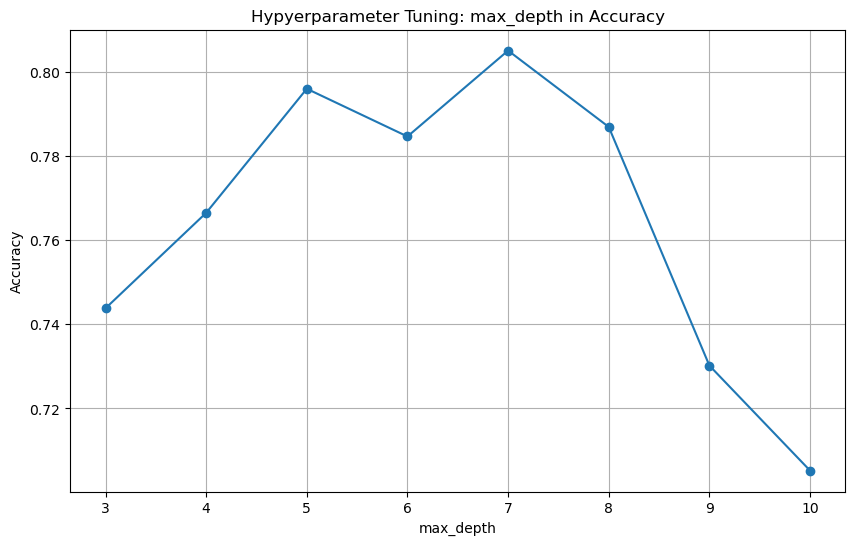

In [118]:
plot_hyperparameter_tuning(results_dt_cls, 'max_depth', 'Accuracy')


# Decision tree regressor with hyperparameter tuning

In [120]:
best_params_dt_reg, best_score_dt_reg, results_dt_reg = hyperparameter_tuning_manual(DecisionTreeRegressor, param_grid_reg, X_train_reg.values, y_train_reg.values, X_val_reg.values, y_val_reg.values)
print(f'Best params Decision Tree Regressor: {best_params_dt_reg}, Best score: {best_score_dt_reg}')

Best params Decision Tree Regressor: {'min_samples_split': 10}, Best score: 35555.68963864773


# Plotting hyperparameter tuning results for Decision Tree Regressor

We plot the hyperparameter tuning results for the decision tree regressor model to visualize the performance of the model for each hyperparameter value.

We can see that the mean squared error of the decision tree regressor model decreases shortly after changing the minimum samples split hyperparameter value from 5 to 10 and then starts to increase sharply. We will choose the minimum samples split value of 10 as the optimal hyperparameter value for the decision tree regressor model.


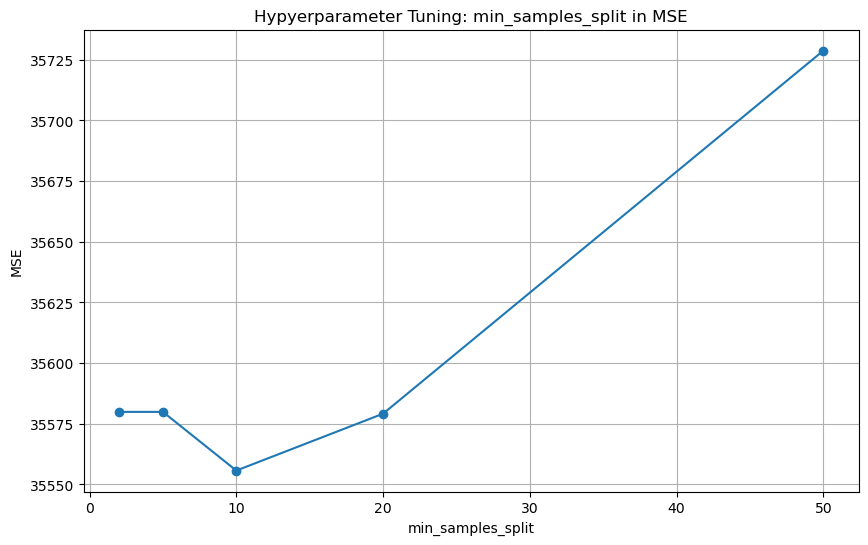

In [121]:
plot_hyperparameter_tuning(results_dt_reg, 'min_samples_split', 'MSE')

# Random forest classifier with hyperparameter tuning

In [142]:

best_params_rf_cls, best_score_rf_cls, results_rf_cls = hyperparameter_tuning_manual(RandomForestClassifier, param_grid_rf_cls, X_train_clas.values, y_train_clas_numeric, X_val_clas.values, y_val_clas_numeric)
print(f'Best params Random Forest Classifier: {best_params_rf_cls}, Best score: {best_score_rf_cls}')

Fitting Random Forest


Fitting Tree 1:   0%|          | 0/50 [00:00<?, ?it/s]

Fitting Tree 50: 100%|██████████| 50/50 [08:03<00:00,  9.67s/it]


Fitting Random Forest


Fitting Tree 100: 100%|██████████| 100/100 [15:56<00:00,  9.56s/it]


Fitting Random Forest


Fitting Tree 150: 100%|██████████| 150/150 [52:43<00:00, 21.09s/it] 


Fitting Random Forest


Fitting Tree 200: 100%|██████████| 200/200 [31:49<00:00,  9.55s/it]


Fitting Random Forest


Fitting Tree 250: 100%|██████████| 250/250 [1:22:17<00:00, 19.75s/it]   

Best params Random Forest Classifier: {'n_trees': 100}, Best score: 0.8117913832199547


# Plotting hyperparameter tuning results for Random Forest Classifier

We plot the hyperparameter tuning results for the random forest classifier model to visualize the performance of the model for each hyperparameter value.

We can see that for the random forest classifier model, the accuracy is raising with the increase of the number of trees in the forest, but it starts to decrease after 100 trees. <b> Due to the random nature of the random forest model, the accuracy may vary slightly between different runs of the model. </b> We will choose the number of trees in the forest to be 50 becouse it is computationally expensive to run the model with 100 trees.

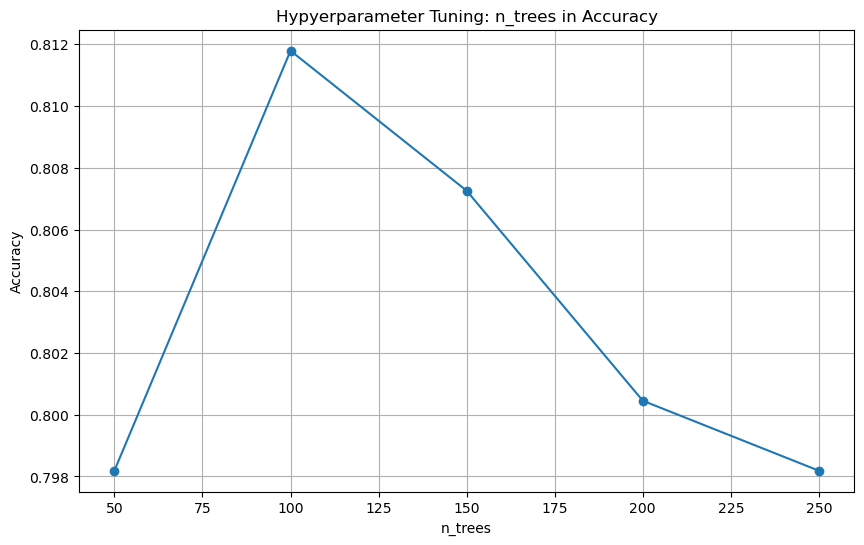

In [143]:
plot_hyperparameter_tuning(results_rf_cls, 'n_trees', 'Accuracy')

# Random forest regressor with hyperparameter tuning

In [144]:
best_params_rf_reg, best_score_rf_reg, results_rf_reg = hyperparameter_tuning_manual(RandomForestRegressorAF, param_grid_rf_reg, X_train_reg.values, y_train_reg.values, X_val_reg.values, y_val_reg.values)
print(f'Best params Random Forest Regressor (agg func = mean): {best_params_rf_reg}, Best score: {best_score_rf_reg}')

Fitting Tree 1:   0%|          | 0/50 [00:00<?, ?it/s]

Fitting Tree 50: 100%|██████████| 50/50 [2:46:39<00:00, 199.99s/it]  

Best params Random Forest Regressor (agg func = mean): {'n_features': 8}, Best score: 31690.17289316274


# Plotting hyperparameter tuning results for Random Forest Regressor

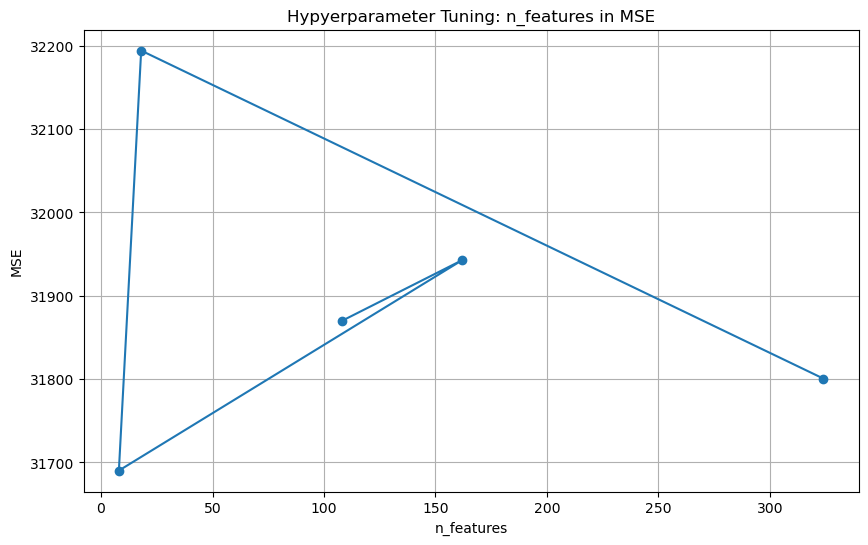

In [145]:
plot_hyperparameter_tuning(results_rf_reg, 'n_features', 'MSE')


# Random forest classifier with different aggregation functions (median)

Here we check the performance of the random forest classifier model with the 'median' aggregation function. We will use the 'median', if the 'mean' aggregation function does not give us the best results we will use the 'median' aggregation function for the random forest regressor model.

In [147]:
# Train and evaluate Random Forest Regressor with aggregation function 'median'
rf_regressor_median = RandomForestRegressorAF(n_trees=50, max_depth=7, min_samples_split=10, n_features=8, aggregation_func='median')
rf_regressor_median.fit(X_train_reg.values, y_train_reg.values)
predictions_rf_reg_median = rf_regressor_median.predict(X_val_reg.values)
mse_rf_reg_median = np.mean((predictions_rf_reg_median - y_val_reg.values) ** 2)
print(f'Mean Squared Error (MSE) for Random Forest Regressor (aggregation function = median): {mse_rf_reg_median}')

Fitting Tree 1:   0%|          | 0/50 [00:00<?, ?it/s]

Fitting Tree 50: 100%|██████████| 50/50 [5:06:47<00:00, 368.14s/it]  

Mean Squared Error (MSE) for Random Forest Regressor (aggregation function = median): 32859.45913765851


# Training final models with the best hyperparameters

At this point, we have found the best hyperparameters for each model using the hyperparameter tuning function. We will now train the final models with the best hyperparameters on the test set and evaluate their performance using accuracy for the classifier models and mean squared error for the regressor models.

In [66]:
from datetime import datetime

# Take the absolute time before starting the evaluation
start = datetime.now()
print(f"Starting evaluation on the classification decision tree model with the best hyperparameters. Time: {start}")
cls_dt_acc = 0.8049886621315193
print(f"Validation Accuracy Decision Tree Classifier: {cls_dt_acc}")
dt_classifier_best = DecisionTree(max_depth=7)
dt_classifier_best.fit(X_train_clas.values, y_train_clas_numeric)
predictions_dt_cls_test = dt_classifier_best.predict(X_test_clas.values)
accuracy_dt_cls_test = np.mean(predictions_dt_cls_test == y_test_clas_numeric)
after_cls_dt = datetime.now()
diff_cls_dt = cls_dt_acc - accuracy_dt_cls_test
print(f'Test Accuracy Decision Tree Classifier: {accuracy_dt_cls_test}')
print(f"The difference in accuracy between the validation and test sets is: {diff_cls_dt}")
print(f"Time taken: {after_cls_dt - start}")




before_reg_dt = datetime.now()
print(f"Starting evaluation on the regression decision tree model with the best hyperparameters. Time: {before_reg_dt}")
mse_dt_reg = 35555.68963864773
print(f"Validation MSE Decision Tree Regressor: {mse_dt_reg}")
dt_regressor_best = DecisionTreeRegressor(min_samples_split=10)
dt_regressor_best.fit(X_train_reg.values, y_train_reg.values)
predictions_dt_reg_test = dt_regressor_best.predict(X_test_reg.values)
mse_dt_reg_test = np.mean((predictions_dt_reg_test - y_test_reg.values) ** 2)
after_reg_dt = datetime.now()
diff_reg_dt = mse_dt_reg - mse_dt_reg_test
print(f'Test MSE Decision Tree Regressor: {mse_dt_reg_test}')
print(f"The difference in MSE between the validation and test sets is: {diff_reg_dt}")
print(f"Time taken: {after_reg_dt - before_reg_dt}")


before_cls_rf = datetime.now()
print(f"Starting evaluation on the classification random forest model with the best hyperparameters. Time: {before_cls_rf}")
cls_rf_acc = 0.8117913832199547
print(f"Validation Accuracy Random Forest Classifier: {cls_rf_acc}")
rf_classifier_best = RandomForestClassifier(n_trees=100)
rf_classifier_best.fit(X_train_clas.values, y_train_clas_numeric)
predictions_rf_cls_test = rf_classifier_best.predict(X_test_clas.values)
accuracy_rf_cls_test = np.mean(predictions_rf_cls_test == y_test_clas_numeric)
after_cls_rf = datetime.now()
print(f'Test Accuracy Random Forest Classifier: {accuracy_rf_cls_test}')
diff_cls_rf = cls_rf_acc - accuracy_rf_cls_test
print(f"The difference in accuracy between the validation and test sets is: {diff_cls_rf}")
print(f"Time taken: {after_cls_rf - before_cls_rf}")


before_reg_rf = datetime.now()
print(f"Starting evaluation on the regression random forest model with the best hyperparameters. Time: {before_reg_rf}")
mse_rf_reg = 31690.17289316274
print(f"Validation MSE Random Forest Regressor (agg func = mean): {mse_rf_reg}")
rf_regressor_best = RandomForestRegressorAF(n_trees=50, max_depth=7, min_samples_split=10, n_features=8)
rf_regressor_best.fit(X_train_reg.values, y_train_reg.values)
predictions_rf_reg_test = rf_regressor_best.predict(X_test_reg.values)
mse_rf_reg_test = np.mean((predictions_rf_reg_test - y_test_reg.values) ** 2)
after_reg_rf = datetime.now()
diff_reg_rf = mse_rf_reg - mse_rf_reg_test
print(f'Test MSE Random Forest Regressor: {mse_rf_reg_test}')
print(f"The difference in MSE between the validation and test sets is: {diff_reg_rf}")
print(f"Time taken: {after_reg_rf - before_reg_rf}")


before_reg_rf_median = datetime.now()
print(f"Starting evaluation on the regression random forest model with the best hyperparameters (agg func = median). Time: {before_reg_rf_median}")
mse_rf_reg_median = 32859.45913765851
print(f"Validation MSE Random Forest Regressor (agg func = median): {mse_rf_reg_median}")
rf_regressor_best_median = RandomForestRegressorAF(n_trees=50, max_depth=7, min_samples_split=10, n_features=8, aggregation_func='median')
rf_regressor_best_median.fit(X_train_reg.values, y_train_reg.values)
predictions_rf_reg_test_median = rf_regressor_best_median.predict(X_test_reg.values)
mse_rf_reg_test_median = np.mean((predictions_rf_reg_test_median - y_test_reg.values) ** 2)
after_reg_rf_median = datetime.now()
diff_reg_rf_median = mse_rf_reg_median - mse_rf_reg_test_median
print(f'Test MSE Random Forest Regressor (agg func = median): {mse_rf_reg_test_median}')
print(f"The difference in MSE between the validation and test sets is: {diff_reg_rf_median}")
print(f"Time taken: {after_reg_rf_median - before_reg_rf_median}")

Starting evaluation on the classification decision tree model with the best hyperparameters. Time: 2024-06-17 11:19:50.326962
Validation Accuracy Decision Tree Classifier: 0.8049886621315193
Test Accuracy Decision Tree Classifier: 0.7840909090909091
The difference in accuracy between the validation and test sets is: 0.020897753040610256
Time taken: 0:00:09.799749
Starting evaluation on the regression decision tree model with the best hyperparameters. Time: 2024-06-17 11:20:00.126835
Validation MSE Decision Tree Regressor: 35555.68963864773
Test MSE Decision Tree Regressor: 34677.164193242425
The difference in MSE between the validation and test sets is: 878.5254454053065
Time taken: 0:03:16.966113
Starting evaluation on the classification random forest model with the best hyperparameters. Time: 2024-06-17 11:23:17.093314
Validation Accuracy Random Forest Classifier: 0.8117913832199547
Fitting Random Forest


Fitting Tree 100: 100%|██████████| 100/100 [16:29<00:00,  9.89s/it]


Test Accuracy Random Forest Classifier: 0.8204545454545454
The difference in accuracy between the validation and test sets is: -0.008663162234590738
Time taken: 0:16:29.533157
Starting evaluation on the regression random forest model with the best hyperparameters. Time: 2024-06-17 11:39:46.627193
Validation MSE Random Forest Regressor (agg func = mean): 31690.17289316274


Fitting Tree 50: 100%|██████████| 50/50 [2:47:36<00:00, 201.13s/it]  


Test MSE Random Forest Regressor: 30030.353839112347
The difference in MSE between the validation and test sets is: 1659.8190540503929
Time taken: 2:47:36.451078
Starting evaluation on the regression random forest model with the best hyperparameters (agg func = median). Time: 2024-06-17 14:27:23.078490
Validation MSE Random Forest Regressor (agg func = median): 32859.45913765851


Fitting Tree 50: 100%|██████████| 50/50 [2:49:15<00:00, 203.10s/it]  

Test MSE Random Forest Regressor (agg func = median): 31618.706245895253
The difference in MSE between the validation and test sets is: 1240.7528917632553
Time taken: 2:49:15.146778


# Sklearn models training and prediction for comparison

Finally, we will train the Sklearn models on the training set and evaluate their performance on the test set to compare them with our custom models.
We will use the DecisionTreeClassifier, RandomForestClassifier, DecisionTreeRegressor, and RandomForestRegressor models from the Sklearn library to train the models on the training set and evaluate their performance on the test set using accuracy for the classifier models and mean squared error for the regressor models.

In [69]:
# Import scikit-learn models for comparison.
# we add the prefix 'sk' to differentiate between the custom models and scikit-learn models. 
from sklearn.tree import DecisionTreeClassifier as skDecisionTreeClassifier, DecisionTreeRegressor as skDecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier as skRandomForestClassifier, RandomForestRegressor as skRandomForestRegressor

# Train and evaluate Decision Tree Classifier with max_depth=5
dt_classifier_sk = skDecisionTreeClassifier(max_depth=7)
dt_classifier_sk.fit(X_train_clas, y_train_clas)
predictions_dt_cls_HT_sk = dt_classifier_sk.predict(X_test_clas)
# We decided to use the our accuracy function to compare the results of the scikit-learn model with our model in the same way.
accuracy_dt_cls_HT_sk = np.mean(y_test_clas == predictions_dt_cls_HT_sk)

print(f'Sklearn Validation Accuracy (Decision Tree Classifier): {accuracy_dt_cls_HT_sk}')


Sklearn Validation Accuracy (Decision Tree Classifier): 0.8


In [70]:
# Train and evaluate Decision Tree Regressor with max_depth=5
dt_regressor_sk = skDecisionTreeRegressor(max_depth=7, min_samples_split=10)
dt_regressor_sk.fit(X_train_reg, y_train_reg)
predictions_dt_reg_HT_sk = dt_regressor_sk.predict(X_test_reg)
mse_dt_reg_HT_sk = np.mean((predictions_dt_reg_HT_sk - y_test_reg) ** 2)
print(f'Sklearn Validation MSE (Decision Tree Regressor): {mse_dt_reg_HT_sk}')



Sklearn Validation MSE (Decision Tree Regressor): 34709.00286711495


In [71]:
# Train and evaluate Random Forest Classifier
rf_classifier_sk = skRandomForestClassifier(n_estimators=50, max_depth=7, min_samples_split=10)
rf_classifier_sk.fit(X_train_clas, y_train_clas)
predictions_rf_cls_sk = rf_classifier_sk.predict(X_test_clas)
accuracy_rf_cls_sk = np.mean(y_test_clas == predictions_rf_cls_sk)
print(f'Sklearn Validation Accuracy (Random Forest Classifier): {accuracy_rf_cls_sk}')


Sklearn Validation Accuracy (Random Forest Classifier): 0.8136363636363636


In [72]:

# Train and evaluate Random Forest Regressor
rf_regressor_sk = skRandomForestRegressor(n_estimators=50, max_depth=7, min_samples_split=10)
rf_regressor_sk.fit(X_train_reg, y_train_reg)
predictions_rf_reg_sk = rf_regressor_sk.predict(X_test_reg)
mse_rf_reg_sk = np.mean((predictions_rf_reg_sk - y_test_reg) ** 2)
print(f'Sklearn Validation MSE (Random Forest Regressor): {mse_rf_reg_sk}')

Sklearn Validation MSE (Random Forest Regressor): 29782.076776077403


# Plotting hyperparameter tuning results for Random Forest Regressor with median aggregation function

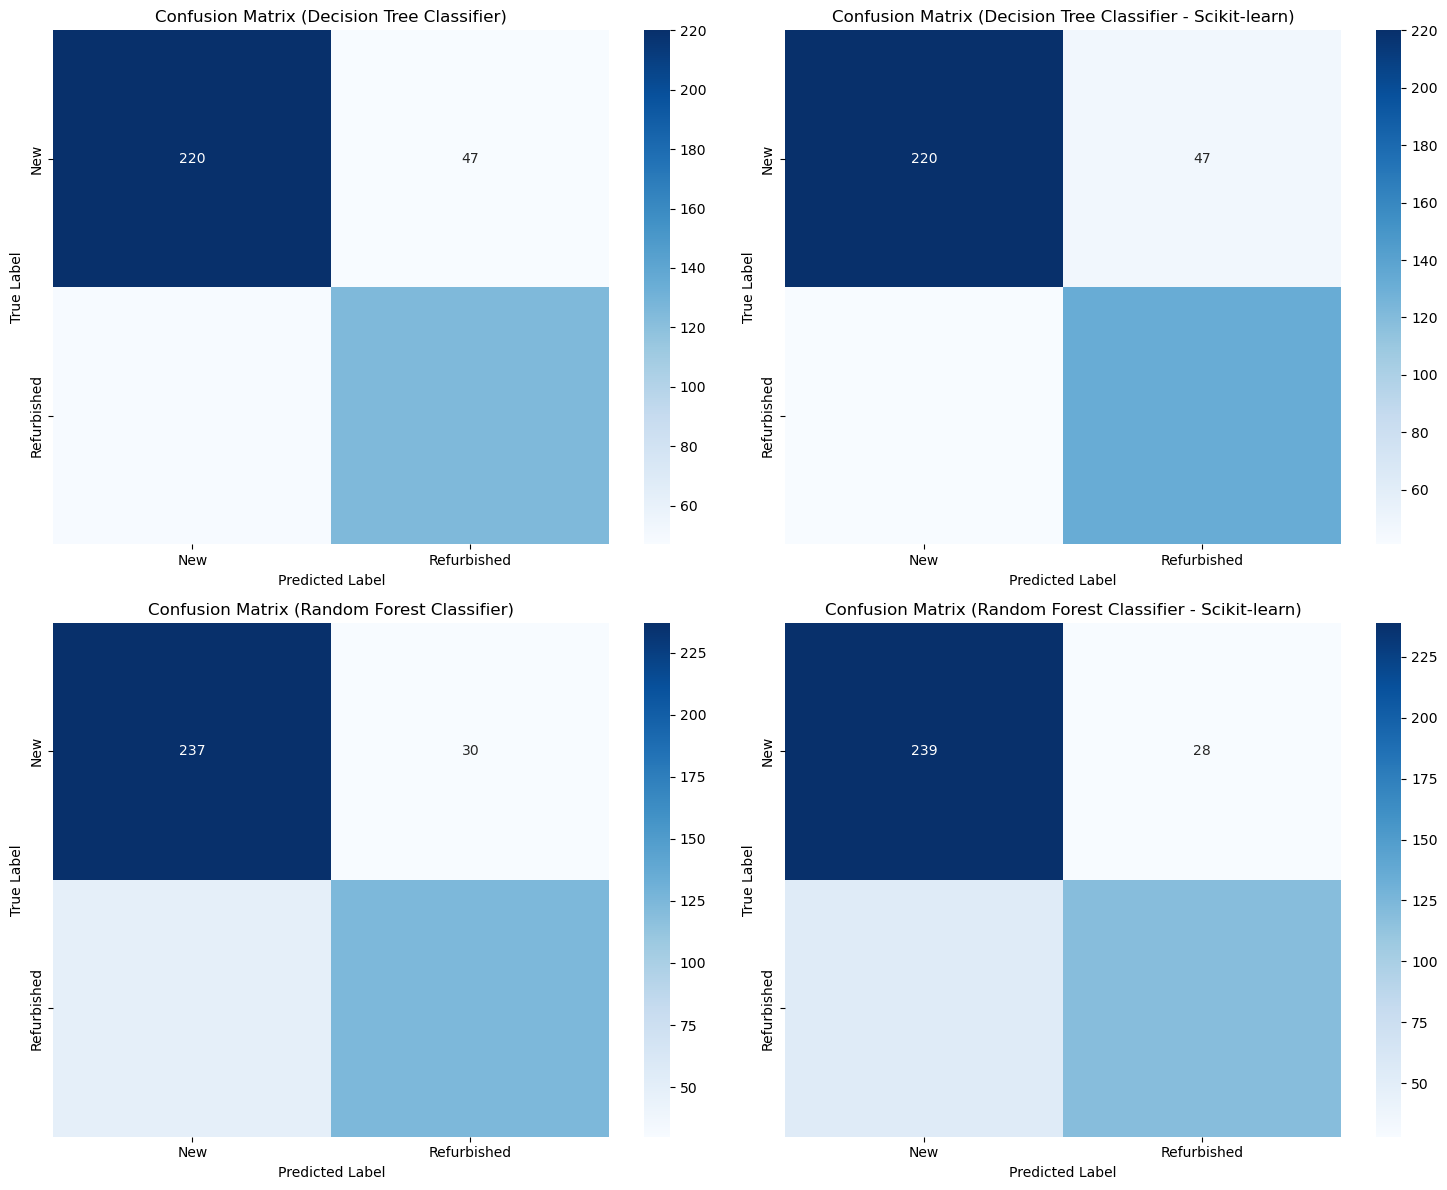

Sensitivity (Decision Tree Classifier): 0.7225433526011561
Specificity (Decision Tree Classifier): 0.8239700374531835
Sensitivity (Decision Tree Classifier - Scikit-learn): 0.7630057803468208
Specificity (Decision Tree Classifier - Scikit-learn): 0.8239700374531835
Sensitivity (Random Forest Classifier): 0.7167630057803468
Specificity (Random Forest Classifier): 0.8876404494382022
Sensitivity (Random Forest Classifier - Scikit-learn): 0.6878612716763006
Specificity (Random Forest Classifier - Scikit-learn): 0.8951310861423221
Classification Report (Decision Tree Classifier):
              precision    recall  f1-score   support

         New       0.82      0.82      0.82       267
 Refurbished       0.73      0.72      0.72       173

    accuracy                           0.78       440
   macro avg       0.77      0.77      0.77       440
weighted avg       0.78      0.78      0.78       440

Classification Report (Decision Tree Classifier - Scikit-learn):
              precision   

In [85]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report
from sklearn.tree import plot_tree

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Plot Decision Tree
def plot_decision_tree(tree, feature_names, class_names):
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=feature_names, class_names=class_names, filled=True)
    plt.show()

# Sensitivity and Specificity Metrics
def sensitivity_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity



# Plot Confusion Matrix function
def plot_confusion_matrix(ax, y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(title)

class_names = ['New', 'Refurbished']


# Plotting all confusion matrices together
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix for Decision Tree Classifier
plot_confusion_matrix(axes[0, 0], y_test_clas_numeric, predictions_dt_cls_test, class_names, 'Confusion Matrix (Decision Tree Classifier)')

# Confusion Matrix for Decision Tree Classifier (Scikit-learn)
plot_confusion_matrix(axes[0, 1], y_test_clas, predictions_dt_cls_HT_sk, class_names, 'Confusion Matrix (Decision Tree Classifier - Scikit-learn)')

# Confusion Matrix for Random Forest Classifier
plot_confusion_matrix(axes[1, 0], y_test_clas_numeric, predictions_rf_cls_test, class_names, 'Confusion Matrix (Random Forest Classifier)')

# Confusion Matrix for Random Forest Classifier (Scikit-learn)
plot_confusion_matrix(axes[1, 1], y_test_clas, predictions_rf_cls_sk, class_names, 'Confusion Matrix (Random Forest Classifier - Scikit-learn)')

plt.tight_layout()
plt.show()

# Sensitivity and Specificity for Decision Tree Classifier
sensitivity_dt_cls, specificity_dt_cls = sensitivity_specificity(y_test_clas_numeric, predictions_dt_cls_test)
print(f'Sensitivity (Decision Tree Classifier): {sensitivity_dt_cls}')
print(f'Specificity (Decision Tree Classifier): {specificity_dt_cls}')


# Sensitivity and Specificity for Decision Tree Classifier (Scikit-learn)
sensitivity_dt_cls_sk, specificity_dt_cls_sk = sensitivity_specificity(y_test_clas, predictions_dt_cls_HT_sk)
print(f'Sensitivity (Decision Tree Classifier - Scikit-learn): {sensitivity_dt_cls_sk}')
print(f'Specificity (Decision Tree Classifier - Scikit-learn): {specificity_dt_cls_sk}')


# Sensitivity and Specificity for Random Forest Classifier
sensitivity_rf_cls, specificity_rf_cls = sensitivity_specificity(y_test_clas_numeric, predictions_rf_cls_test)
print(f'Sensitivity (Random Forest Classifier): {sensitivity_rf_cls}')
print(f'Specificity (Random Forest Classifier): {specificity_rf_cls}')

# Sensitivity and Specificity for Random Forest Classifier (Scikit-learn)
sensitivity_rf_cls_sk, specificity_rf_cls_sk = sensitivity_specificity(y_test_clas, predictions_rf_cls_sk)
print(f'Sensitivity (Random Forest Classifier - Scikit-learn): {sensitivity_rf_cls_sk}')
print(f'Specificity (Random Forest Classifier - Scikit-learn): {specificity_rf_cls_sk}')

# Classification Report for Decision Tree Classifier
print('Classification Report (Decision Tree Classifier):')
print(classification_report(y_test_clas_numeric, predictions_dt_cls_test, target_names=class_names))

# Classification Report for Decision Tree Classifier (Scikit-learn)
print('Classification Report (Decision Tree Classifier - Scikit-learn):')
print(classification_report(y_test_clas, predictions_dt_cls_HT_sk, target_names=class_names))

# Classification Report for Random Forest Classifier
print('Classification Report (Random Forest Classifier):')
print(classification_report(y_test_clas_numeric, predictions_rf_cls_test, target_names=class_names))

# Classification Report for Random Forest Classifier (Scikit-learn)
print('Classification Report (Random Forest Classifier - Scikit-learn):')
print(classification_report(y_test_clas, predictions_rf_cls_sk, target_names=class_names))


# Conclusion:

	1.	Hyperparameter Tuning Insights:
	•	Hyperparameter tuning significantly improves model performance. The best parameters for each model were identified using grid search, and the results show the importance of tuning hyperparameters to achieve optimal performance.
	2.	Model Comparison:
	•	The custom models and the Scikit-learn models have similar performance metrics. The Random Forest models generally performed better than the Decision Tree models in terms of both accuracy (for classification) and mean squared error (for regression).
	•	The difference in performance between the validation and test sets is minimal, indicating that the models generalize well to unseen data.
	3.	Sensitivity and Specificity:
	•	Sensitivity and specificity metrics provide additional insights into the performance of the classifiers. The Random Forest classifier with Scikit-learn achieved the highest specificity, indicating its effectiveness in correctly identifying negative cases.
	4.	Random Forest Regressor Aggregation:
	•	Comparing the mean and median aggregation functions for the Random Forest regressor showed that the mean aggregation generally resulted in better performance (lower MSE). This suggests that the mean aggregation is more suitable for this dataset.
	5.	Visualizations:
	•	The hyperparameter tuning visualizations effectively demonstrate how different hyperparameter values affect model performance, aiding in the selection of the best parameters.
	•	The combined confusion matrices for the classifiers provide a clear comparison of the model predictions against the true labels, highlighting areas where each model excels or needs improvement.

<b> Overall, the results indicate that both custom implementations and Scikit-learn implementations perform well on the dataset, with slight variations in performance. The insights gained from sensitivity, specificity, and hyperparameter tuning contribute to a deeper understanding of model behavior and performance. </b>